In [1]:
import numpy as np
import xarray as xr
import nc_time_axis
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import tracks
%matplotlib inline

In [2]:
ds_tc = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV/', ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [3]:
ds_sd = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV.seeds/', ext='.seeds')

REF.001: 5.000 years, 2214 tracks
REF.002: 5.000 years, 2146 tracks
REF.003: 5.000 years, 2236 tracks
REF.004: 5.000 years, 2224 tracks
REF.005: 5.000 years, 2284 tracks
REF.006: 5.000 years, 2210 tracks
RCP.001: 5.000 years, 1532 tracks
RCP.002: 5.000 years, 1494 tracks
RCP.003: 5.000 years, 1439 tracks
RCP.004: 5.000 years, 1486 tracks
RCP.005: 5.000 years, 1501 tracks
RCP.006: 5.000 years, 1462 tracks
SAI.001: 5.000 years, 1822 tracks
SAI.002: 5.000 years, 1887 tracks
SAI.003: 5.000 years, 1936 tracks
SAI.004: 5.000 years, 1978 tracks
SAI.005: 5.000 years, 1855 tracks
SAI.006: 5.000 years, 1817 tracks


In [6]:
# select Ref.001
dsi_tc = ds_tc['Reference'].where(ds_tc['Reference'].ens==1, drop=True)
dsi_sd = ds_sd['Reference'].where(ds_sd['Reference'].ens==1, drop=True)

# loop through mature TCs
for tid in dsi_tc.id.astype('int'):
    tc = dsi_tc.sel(id=tid).isel(dtime=0)
    time = tc.time.item() # initial TC time, try to find in seeds
    sds = dsi_sd.where(dsi_sd.time==time, drop=True)
    if sds.id.size == 0:
        print(tid.item(), '-')
        continue
    dlon = (sds.lon - tc.lon + 540) %360 - 180
    dlat = (sds.lat - tc.lat)
    dist = np.sqrt(dlon**2 + dlat**2)
    print(tid.item(), dist.min().item())

1 -
2 0.0
3 20.16591360613909
4 -
5 0.0
6 -
7 -
8 25.663657650061946
9 71.35142532991917
10 -
11 23.290344456706414
12 -
13 -
14 0.0
15 179.96613945539852
16 8.518701810802934
17 0.0
18 -
19 -
20 166.2425174091411
21 -
22 0.0
23 31.181925570503658
24 43.880419136583036
25 56.36004230500892
26 -
27 28.813310670762384
28 -
29 15.66899803086902
30 -
31 -
32 -
33 37.52642667480589
34 126.2994042224389
35 -
36 -
37 103.88110913970286
38 -
39 -
40 -
41 0.0
42 0.0
43 41.36484247808153
44 -
45 -
46 -
47 0.0
48 24.73960518182783
49 23.80674638859958
50 74.34623402721238
51 10.751246374774382
52 -
53 18.537760304667287
54 0.0
55 0.0
56 -
57 -
58 53.15816421948679
59 35.610394325610386
60 0.0
61 0.0
62 -
63 133.17774741393387
64 -
65 111.40459755900754
66 77.39272149190343
67 -
68 89.55060845600583
69 0.0
70 21.7798768655791
71 87.82786476888243
72 36.52320583913037
73 63.53509482854649
74 61.566525653108734
75 13.30959727434897
76 14.103967926830466
77 125.63289109138412
78 0.0
79 0.0
80 -
81 -


In [85]:
# select Ref.001
dsi_tc = ds_tc['Reference'].where(ds_tc['Reference'].ens==1, drop=True)
dsi_sd = ds_sd['Reference'].where(ds_sd['Reference'].ens==1, drop=True)

# select TC with id=200
matches = []
for tid in dsi_tc.id.astype('int')[:]:
    # tid = 20
    tc = dsi_tc.sel(id=tid).isel(dtime=0)
    time = tc.time.item()
    
    # select all final seed track points in the 12 hours prior to TC genesis
    #times = np.arange(time-0.5,time+0.1,0.125)
    #sds = dsi_sd.where(dsi_sd.time.isin(times), drop=True)
    sds = dsi_sd.where((dsi_sd.time>=time-7) & (dsi_sd.time<=time), drop=True)
    if sds.id.size == 0:
        print(f"TC {int(tid):03d} X no match")
        continue
    sds = sds.isel(dtime=sds.time.argmax('dtime'))
    
    
    # calculate distance in degrees between last seed position and TC genesis position
    dlon = (sds.lon - tc.lon + 540) %360 - 180
    dlat = (sds.lat - tc.lat)
    dist = np.sqrt(dlon**2 + dlat**2)
    
    # calculate time difference between last seed occurrence and TC genesis
    dtime = tc.time - sds.time

    # loop through seed distances, in order of ascending time difference
    match = False
    for dst in dist.sortby(dtime): 
        dt = dtime.sel(id=dst.id)
        if dst < dt * 12 + 0.1: # maximum speed 12 deg/day ~55 km/h
            match = True
            matches.append(int(dst.id))
            print(f"TC {int(tid):03d} > SD {int(dst.id):04}: dist = {dst:6.2f} deg, dt = {dt:5.3f} days")
            break
    if not match:
        print(f"TC {int(tid):03d} X no match")
print(f"num matches = {len(matches)} ({len(matches)/dsi_tc.id.size*100:.1f} %)")
print(f"num unique = {len(np.unique(matches))} ({len(np.unique(matches))/dsi_tc.id.size*100:.1f} %)")

TC 001 > SD 0005: dist =  16.63 deg, dt = 1.750 days
TC 002 > SD 0008: dist =   0.00 deg, dt = 0.000 days
TC 003 > SD 0012: dist =  18.44 deg, dt = 2.250 days
TC 004 X no match
TC 005 > SD 0020: dist =   0.00 deg, dt = 0.000 days
TC 006 > SD 0015: dist =  26.03 deg, dt = 4.125 days
TC 007 > SD 0013: dist =   7.19 deg, dt = 1.500 days
TC 008 > SD 0013: dist =  14.81 deg, dt = 4.125 days
TC 009 > SD 0023: dist =   3.76 deg, dt = 2.625 days
TC 010 > SD 0025: dist =   2.60 deg, dt = 3.625 days
TC 011 > SD 0028: dist =   8.34 deg, dt = 6.000 days
TC 012 X no match
TC 013 > SD 0033: dist =   6.16 deg, dt = 2.875 days
TC 014 > SD 0036: dist =   0.00 deg, dt = 0.000 days
TC 015 X no match
TC 016 X no match
TC 017 > SD 0047: dist =   0.00 deg, dt = 0.000 days
TC 018 > SD 0051: dist =   2.00 deg, dt = 1.000 days
TC 019 > SD 0053: dist =  13.76 deg, dt = 3.375 days
TC 020 > SD 0053: dist =   6.58 deg, dt = 1.750 days
TC 021 > SD 0051: dist =  12.76 deg, dt = 5.750 days
TC 022 > SD 0060: dist =   

In [78]:
diff = dsi_tc.isel(dtime=range(0,2)).diff('dtime')
dist = np.sqrt(((diff.lon + 540) % 360 - 180)**2 + diff.lat**2).mean('dtime')
dist.quantile([0.9,0.98,1])

<xarray.DataArray (quantile: 3)> Size: 24B
array([0.9375    , 1.04843032, 1.56323368])
Coordinates:
  * quantile  (quantile) float64 24B 0.9 0.98 1.0

In [73]:
diff

<xarray.Dataset> Size: 114kB
Dimensions:    (id: 475, dtime: 1, data: 13)
Coordinates:
  * dtime      (dtime) float64 8B 0.125
  * data       (data) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
  * id         (id) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 472.0 473.0 474.0 475.0
    ens        (id) float64 4kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Data variables: (12/16)
    TC_tracks  (id, dtime, data) float64 49kB 0.125 0.3125 ... 8.56e-07 0.04647
    num_days   (id) float64 4kB 1.095e+04 1.095e+04 ... 1.095e+04 1.095e+04
    time       (id, dtime) float64 4kB 0.125 0.125 0.125 ... 0.125 0.125 0.125
    lon        (id, dtime) float64 4kB 0.3125 0.0 -0.3125 ... 0.0 -0.3125 0.0
    lat        (id, dtime) float64 4kB 0.0 -0.2347 0.0 ... 0.2347 0.2347 0.0
    PSL        (id, dtime) float64 4kB 0.3383 -0.03455 0.3474 ... -2.297 -1.619
    ...         ...
    SSTmon     (id, dtime) float64 4kB -0.002105 0.1441 ... -0.05918 0.0
    RV         (id, dtime) float64 4kB 0.000195 2.75e-06 ... -7.271e-08
    Vshear     (id, dtime) float64 4kB -1.115 0.3715 -0.2578 ... -0.2568 -0.7505
    PRECT      (id, dtime) float64 4kB -18.04 -3.256 9.046 ... -14.07 3.081
    TEMP       (id, dtime) float64 4kB -0.1372 0.0856 ... -0.7506 0.04647
    year       (id, dtime) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [33]:
sd = dsi_sd.sel(id=dist.id.item())
tc = dsi_tc.sel(id=tid)

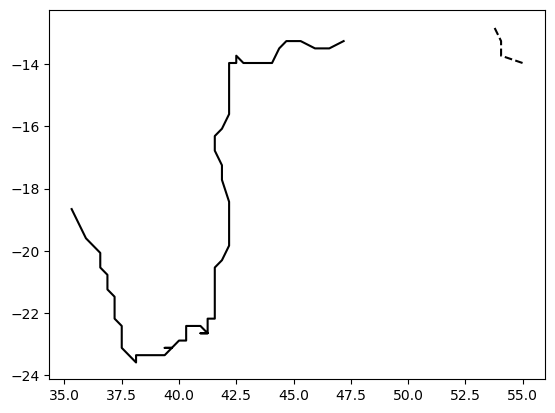

In [34]:
ax = plt.axes()
ax.plot(tc.lon, tc.lat, c='k')
ax.plot(sd.lon, sd.lat, c='k', ls='--')